In [1]:
#Import of certain python libraries used in the project
from CoolProp.CoolProp import PropsSI
import numpy as np
import matplotlib.pyplot as plt

# General overview of symbols used in CoolProp
# ... T for (T)emperature
# ... P for (P)ressure
# ... D for (D)ensity
# ... Q for vapor quality x
# ... C for specific heat

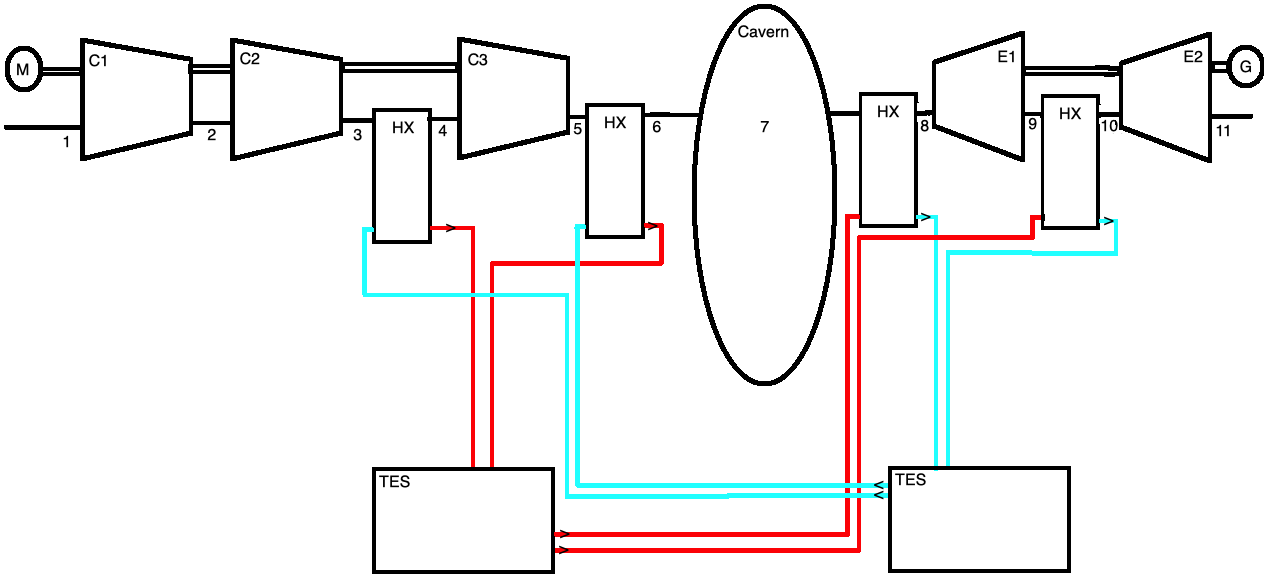

Figure of the modeled system where M is the motor, C the compressor, HX the heat exchanger, E the expander, G the generator and TES the thermal energy storage. <br>
In this model, pressure drops in the cavern and over heat exchangers have been neglected. This means that p5 till p8 all have the same value. In the code all theses values are reffered to as p7. <br>
In addition, the first 2 compressors have a fixed pressure ratio while the third is variable. <br>
THe same is true for the expanders, the first is variable and the second is fixed.


In [2]:
#Boundary conditions

#Ambiant air conditions (average Netherlands)
p1 = 1.013e5    #Pa        
T1 = 11+273.15 #K

#Fixed pressures (see Chapter 2, Design)
p2  = 13*p1   #fixed ratio
p3  = 2.81*p2 #fixed ratio
p4  = p3

p9  = 30*p1   #fixed ratio
p10 = p9
p11 = p1

#Cavern parameters
V = 50000    # m^3 
pmax = 100e5 # Pa      
pmin = 60e5  # Pa

#Initial pressure in cavern
p7 = pmin

#List of efficiencies from literature
#Symbols are explained in the figure found above
eff_M   = 0.98 #[-]
eff_G   = 0.98 #[-]

eff_C   = 0.9  #[-]
eff_C1  = 0.92 #[-]
eff_C2  = 0.90 #[-] 

#Efficiency depends on the required pressure ratio, this formula is only valid in required range
eff_C3  = 5.625*10**(-8)*p7+0.3455  #[-]

eff_E   = 0.9   #[-]
eff_E1  = 0.835 #[-]
eff_E2  = 0.852 #[-]

eff_TES = 0.97 #[-]

#Ideal heat exchanger functionality
T4 = T1
T6 = T1

#Temperatures of water hot/cold for HX functionality
Twh = 95+273.15 #K
Twl = T1

#Miscellaneous           
R = 8.3145      #J / (mol K)  
Mm = 28.97e-3   #kg / mol
Ra = R/Mm       #J / (kg K)
dt =1           #s
t_rampup = 5*60 #s
Pwind = 100e6   #W
Pout = 100e6    #W
gamma=1.37      #[-]


In [3]:
#Functions

#Function to determine input power, scales linearly in time in start up phase.
def Pin(t):
    if t > t_rampup:
        Pin = Pwind
    else:
        Pin = Pwind * t/t_rampup
    return Pin

#Function to determine compressor output temperature
def Tpressurize(Tin, pin, pout, eff_E):
    h0 = PropsSI("H", "P", pin, "T", Tin, "air")
    s0 = PropsSI("S", "P", pin, "T", Tin, "air")
    
    # s1,s = s0 (isentropic)
    s1s = s0 
    h1s = PropsSI("H", "S", s1s, "P", pout, "air")
    
    # eta_c = (h1s - h0)/ (h1 - h0)
    h1 = h0 + 1/eff_C * (h1s - h0) 

    T1 = PropsSI("T", "H", h1, "P", pout, "air")
    return T1


#Function to determine expander output temperature
def Tdepressurize(Tin, pin, pout, eff_E):
    h0 = PropsSI("H", "P", pin, "T", Tin, "air")
    s0 = PropsSI("S", "P", pin, "T", Tin, "air")
    
    # s1,s = s0
    s1s = s0
    h1s = PropsSI("H", "S", s1s, "P", pout, "air")
    
    # eta_t = (h0 - h1)/ (h0 - h1s)
    h1 = h0 - eff_E * (h0 - h1s) 

    T1 = PropsSI("T", "H", h1, "P", pout, "air")
    return T1

#Generalised function for temperature after (de)compression
def Tcompr(pin,pout,Tin):
    Tout_s = Tin*(pout/pin)**((gamma-1)/gamma)
    Tout   = Tin + (Tout_s-Tin)/eff_C
    return Tout


#Get enthalpy for known T,p
def hTp(p,T):
    return PropsSI("H","P",p,"T",T,"air")


#Function to determine the mass flow at that moment in time
def mdot_in(t, p7):
    
    #Condition to see if the cavern is full
    if p7 < pmax:
        
        #Calulation of specific work per compressor, dh3 changes every calculation due to change in p7
        dh1 = hTp(p2,T2)-hTp(p1,T1)
        dh2 = hTp(p3,T3)-hTp(p2,T2) 
        dh3 = hTp(p7,T5)-hTp(p4,T4)
        
        #Code to make a graph of specific work
        w1.append((hTp(p2,T2)-hTp(p1,T1))/1000)
        w2.append((hTp(p3,T3)-hTp(p2,T2))/1000)
        w3.append((hTp(p7,T5)-hTp(p4,T4))/1000)
        
        #Calculate efficiency of third compressor
        eff_C3  = 5.625*10**(-8)*p7+0.3455

        return (Pin(t)*(eff_M))/(dh1/eff_C1+dh2/eff_C2+dh3/eff_C3)
    
    #If the cavern is full, there is no mass flow.
    else:
        
        #Code to make a graph of specific work
        w1.append(0)
        w2.append(0)
        w3.append(0)
        return 0

#Function to determine the mass flow at that moment in time
def mdot_out(t,p7):
    
    #Condition to see if the cavern is empty
    if p7 > pmin:
        
        #Calulation of specific work per compressor, dh1 changes every calculation due to change in p7
        dh1 = hTp(p7,T8)-hTp(p9,T9)
        dh2 = hTp(p10,T10)-hTp(p11,T11)
        
        #Code to make a graph of specific work
        w4.append((hTp(p7,T8)-hTp(p9,T9))/1000)
        w5.append((hTp(p10,T10)-hTp(p11,T11))/1000)
        
        return (Pout/eff_G/(dh1*eff_E1+dh2*eff_E2))
    
    #If the cavern is empty, there is no mass flow.
    else:
        
        #Code to make a graph of specific work
        w4.append(0)
        w5.append(0)
        return 0
        
#Function to calculate the amount of heat per second transferred to water
def Q_HX(Tin,Tout):
    #cp is determined at the average temperature due to it not being constant
    Tav = (Tin+Tout)/2
    cp = PropsSI('C','T',Tav,'P',p7,'air')
    Qdot = mdot*cp*(Tout-Tin)
    return Qdot

#Function to calculate the required flow of water
def flow_cooling_liquid(Tin,Tout):
    cp = PropsSI('C','T',(Twh+Twl)/2,'P',p1,'water')
    mflow = -Q_HX(Tin,Tout)/cp/(Twh-Twl)
    return mflow

#Function to calculate the round trip efficiency by integrating power input and output
def efficiency():
    Ein = Pwind*t_rampup/2+Pwind*(tcharge-t_rampup)
    Eout = Pout*tdecharge
    return Eout/Ein
    


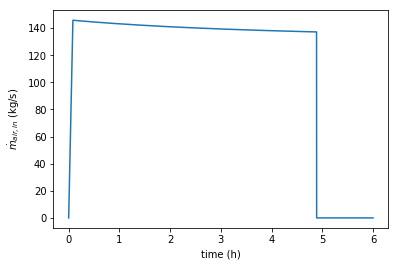

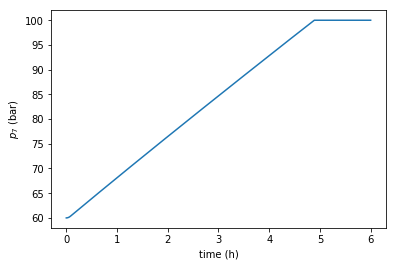

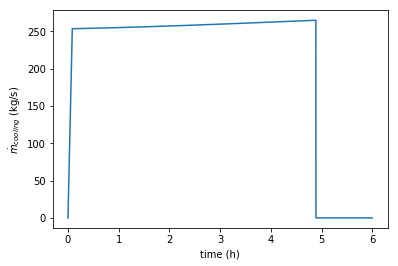

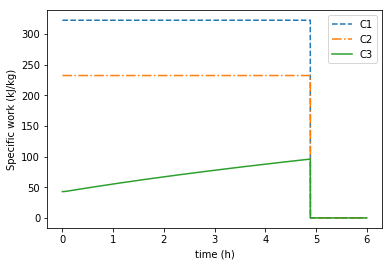

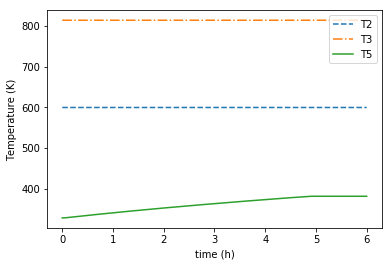

In [4]:
#Series of empty lists to store values 
x = []
y = []
z = []

w1 = []
w2 = []
w3 = []

t2 = []
t3 = []
t5 = []

mflow = []  
Qstored = 0

#Max time to insure that code stops eventually
tmax=6*60*60

#Calculate Temperature after compressor stage, needed for enthalphy
#Outside of loop due to fixed p_ratio therefore fixed temperatures and increase in computation speed
T2 = Tcompr(p1,p2,T1)
T3 = Tcompr(p2,p3,T2)

#Fill cavern and show various graphs 
for t in np.linspace(0, tmax, tmax//dt):
            
    #Calculate Temperature after compressor stage, needed for enthalphy
    T5 = Tcompr(p4,p7,T4)
    
    #Calculate mass flow and update pressure and stored heat
    mdot = mdot_in(t,p7)
    p7 += mdot * dt * Ra * T6 / V
    Qstored += Q_HX(T3,T4) + Q_HX(T5,T6)
    
    #Code used for graphs
    mflow.append(flow_cooling_liquid(T3,T4)+flow_cooling_liquid(T5,T6))
    
    x.append(t/60/60)
    y.append(mdot)
    z.append(p7/1e5)
    
    t2.append(T2)
    t3.append(T3)
    t5.append(T5)


#Calculate total heat that can be extracted from TES
Q_TES = abs(Qstored)*eff_TES

#Determine for how long power was provided
for t in range(t_rampup,tmax,dt):
    if y[t] != 0:
        tcharge = t

#Series of plot commands
plt.plot(x, y)
plt.xlabel("time (h)")
plt.ylabel(r"$\dot m_{air,in}$ (kg/s)")
plt.show()

plt.plot(x,z)
plt.xlabel("time (h)")
plt.ylabel(r"$p_7$ (bar)")
plt.show()

plt.plot(x,mflow)
plt.xlabel("time (h)")
plt.ylabel(r"$\dot m_{cooling}$ (kg/s)")
plt.show()

plt.plot(x,w1,label='C1',linestyle='--')
plt.plot(x,w2,label='C2',linestyle='-.')
plt.plot(x,w3,label='C3',linestyle='-')
plt.xlabel("time (h)")
plt.ylabel("Specific work (kJ/kg)")
plt.legend()
plt.show()

plt.plot(x,t2,label="T2",linestyle='--')
plt.plot(x,t3,label="T3",linestyle='-.')
plt.plot(x,t5,label="T5",linestyle='-')
plt.xlabel('time (h)')
plt.ylabel("Temperature (K)")
plt.legend()
plt.show()
 

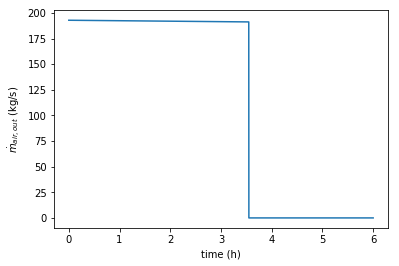

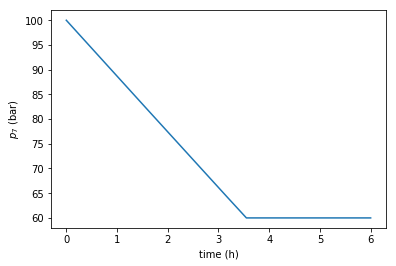

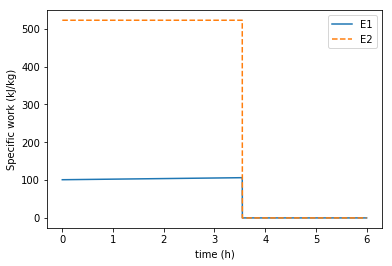

In [5]:
#Series of empty lists to store values
x = []
y = []
z = []

w4= []
w5 = []

tmax=6*60*60
Qtaken=0

#Temperature rough approximation
cp_air=1007
Qdot = Q_TES/(0.72*tcharge)  #qdot calculation with estimated decharge time
dT=Qdot/210/cp_air

T8=T6 +0.1*dT           #0.1 and 0.9 weights are based on pressure ratios
T9=Tcompr(p7,p9,T8)
T10=T9 +0.9*dT
T11=Tcompr(p10,p11,T10)

#Empty cavern and show various graphs 
for t in np.linspace(0, tmax, tmax//dt):

    
    #Calculate mass flow and update pressure and stored heat
    mdot = mdot_out(t,p7)
    dp = mdot * dt * Ra * T6 / V
    p7 -= dp
    Qtaken += Q_HX(T6,T8) + Q_HX(T9,T10)
    
    #Code used for graphs
    x.append(t/60/60)
    y.append(mdot)
    z.append(p7/1e5)

    

#Determine for how long power was provided
for t in range(t_rampup,tmax,dt):
    if y[t] != 0:
        tdecharge = t

#Series of plot commands
plt.plot(x, y)
plt.xlabel("time (h)")
plt.ylabel(r"$\dot m_{air,out}$ (kg/s)")
plt.show()

plt.plot(x,z)
plt.xlabel("time (h)")
plt.ylabel(r"$p_7$ (bar)")
plt.show()

plt.plot(x,w4,label='E1',linestyle='-')
plt.plot(x,w5,label='E2',linestyle='--')
plt.xlabel("time (h)")
plt.ylabel("Specific work (kJ/kg)")
plt.legend()
plt.show()

    

In [6]:
print("The roundtrip efficiency that is obtained from this model is {0:.2f} percent.".format(efficiency()*100))

The roundtrip efficiency that is obtained from this model is 73.23 percent.


In [7]:
if T11 < 273:
    print("The output temperature is {0:.1f} K, this should be considered for safety.".format(T11))
else:
    print("The output temperature is {0:.1f} K.".format(T11))

The output temperature is 250.5 K, this should be considered for safety.


In [8]:
if Qtaken/Q_TES < 1:
    print("The extracted fraction of heat is {0:.2f}, which is lower then 1 which means its possible.".format(Qtaken/Q_TES))
    print("Not all heat from TES is used")
else:
    print("The estimation resulted in a non physical process, please reconsider the values.")

The extracted fraction of heat is 0.98, which is lower then 1 which means its possible.
Not all heat from TES is used


In [9]:
if T11 < 273:
    #Use of rest energy in TES to warm outlet air
    mflow_out = y[round(tdecharge/2)] #approximation of average mass flow out
    m_tot = mflow_out*tdecharge
    T11+=(Q_TES-Qtaken)/(m_tot*cp_air)
    print("If non used TES energy was used to warm the cold air, it could be heated to {0:.1f} K".format(T11))


If non used TES energy was used to warm the cold air, it could be heated to 263.0 K


In [10]:
#Charge and decharge time for reference
print("The charge time is {0:.2f} hours.".format(tcharge/3600))
print("The decharge time is {0:.2f} hours.".format(tdecharge/3600))

The charge time is 4.89 hours.
The decharge time is 3.55 hours.
